# Inversion on Unimak Island

This is the noteboook that solves the inversion for one InSAR geometry. VMOD works with outputs from MintPy

## Load libraries

In [1]:
%matplotlib widget
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util

## Plot Coherence

This cell plots the coherence so the user can choose the appropiated coherence threshold


[np.float64(-165.03240751627823), np.float64(-163.85380297107693), np.float64(54.353731366882556), np.float64(55.00885181538406)]


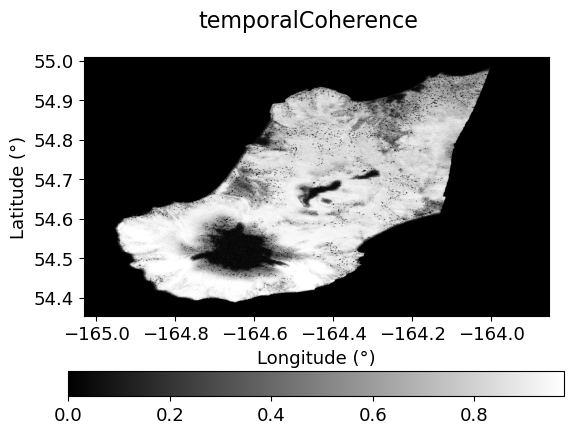

In [31]:
h5file='examples/insar/temporalCoherence_des.h5'
key='temporalCoherence'

coh=util.read_dataset_h5(h5file,key)

## Choose Area of interest

In this step the user needs to draw a box for the Area of Interest drag-clicking.

Please select the area of interest


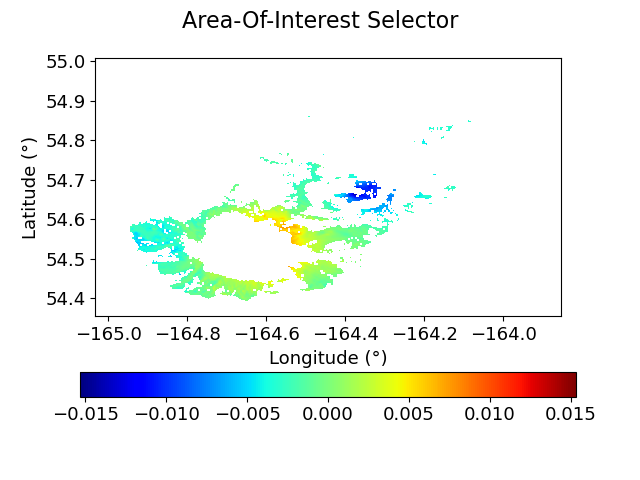

In [33]:
%matplotlib widget

h5file='examples/insar/velocity_des.h5'
key='velocity'
aoi=util.AOI_Selector(h5file,key,coh,cohth=0.85)

## Choose a reference pixel

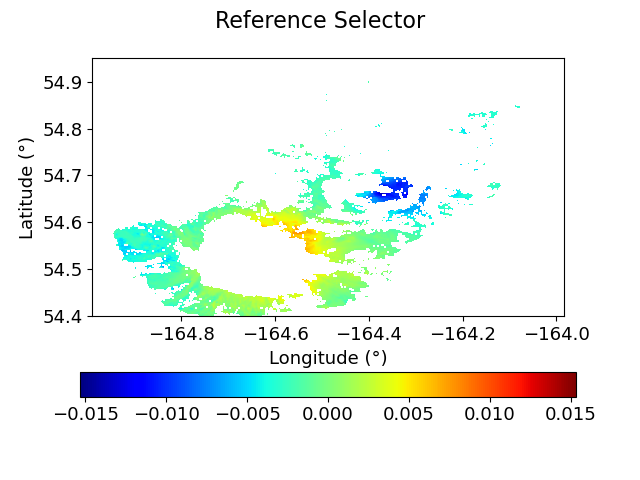

In [34]:
ref=util.Ref_Insar_Selector_Pre(aoi)

## Plot Incidence and Azimuth angles from AOI

In [6]:
mask_des=np.isnan(ref.dataset)
np.save('mask_des.npy',mask_des)

[np.float64(-164.97739101452567), np.float64(-164.0556847558114), np.float64(54.371317218439614), np.float64(54.92839242975042)]


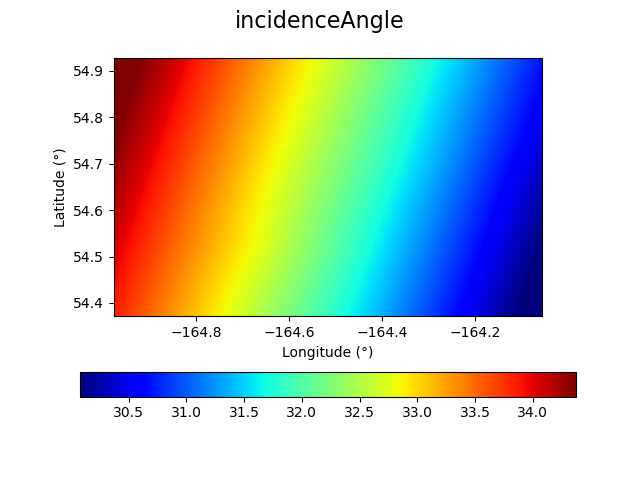

In [8]:
h5file='examples/insar/geometryGeo_des.h5'
key='incidenceAngle'
inc=util.read_dataset_h5(h5file,key,plot=True,aoi=aoi)

[np.float64(-164.97739101452567), np.float64(-164.0556847558114), np.float64(54.371317218439614), np.float64(54.92839242975042)]


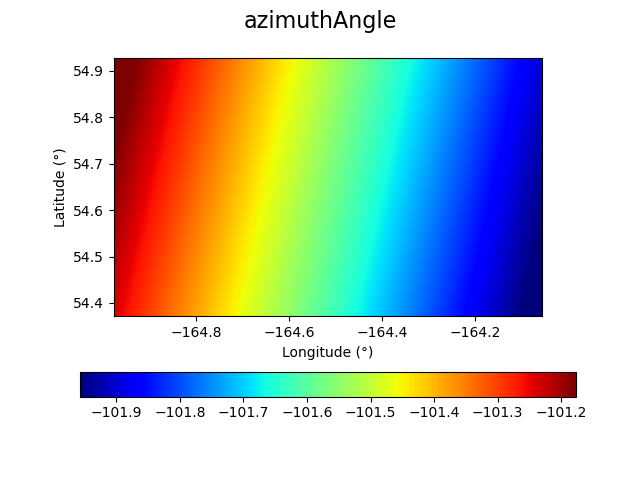

In [9]:
h5file='examples/insar/geometryGeo_des.h5'
key='azimuthAngle'
az=util.read_dataset_h5(h5file,key,plot=True,aoi=aoi)
az=-1*az+90

## Downsample the image using a Quadtree

In this cell the user can downsample the image using a quadtree that is driven by the variance. The user needs to choose a variance threshold

In [10]:
csvfile='unimak_des.csv'
util.get_quadtree(ref,az,inc,name=csvfile,th=np.nanvar(ref.dataset)/100)

/home/jovyan/notebooks/ASF/vmod_git2/vmod/vmod/util.py:206: RuntimeWarning: Mean of empty slice
  if not np.isnan(np.nanmean(xx)):


Final samples:  1460


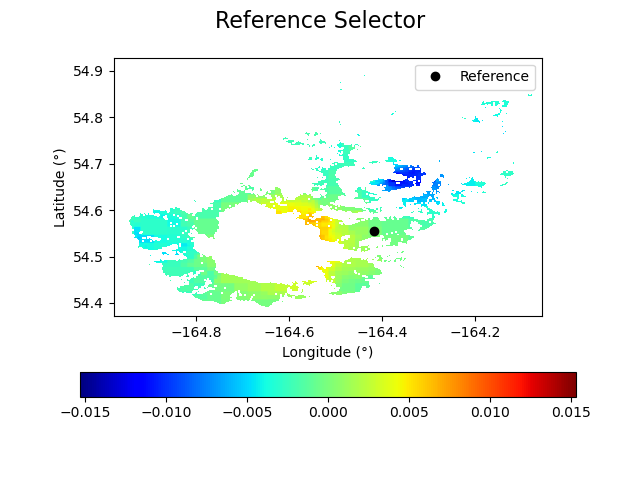

In [11]:
ref_quad=util.Ref_Insar_Selector(csvfile,mask=mask_des,vmin=aoi.vmin,vmax=aoi.vmax)

## Create the InSAR object from the downsampled image

Here the 'Insar' object is created from the csv file that has the downsampled image

In [12]:
from vmod.data import Insar
#xs,ys,azs,lks,los,elos,ref=util.read_dataset_csv('fisher.txt')
#xs,ys,azs,lks,los,elos,ref=util.read_dataset_csv('fisher_ref.txt')
#obs=Insar()
#obs.add_vecs(azs,lks)
#obs.add_xs(xs)
#obs.add_ys(ys)
#obs.add_los(los)
#obs.add_ref(ref)
#obs=util.csv2insar('fisher.txt')
csvfile_ref='unimak_des_ref.csv'
obs_des=Insar()
obs_des.importcsv(csvfile_ref,ori=[-164.5,54.7])

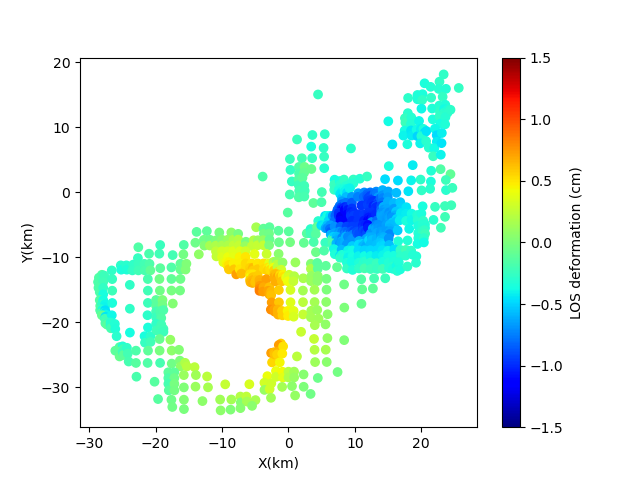

In [14]:
plt.figure()
plt.scatter(obs_des.xs/1e3,obs_des.ys/1e3,c=obs_des.get_data()*1e2,cmap='jet',vmin=-1.5,vmax=1.5)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (cm)')

## Create model objects 

Here the model objects are initialized with the bounds for the parameters. Then, the objects are added to the inversion.

In [15]:
from vmod.source import Mctigue
from vmod.source import Okada
from vmod.inverse import Inverse

okd_des = Okada(obs_des)
okd_des.set_type('open')
#Bounds for parameters
okd_des.set_bounds(low_bounds = [-20000,-20000,1e3,1e1,1e1,-100,1,1], high_bounds = [20000,20000,15e3,3e4,3e4,1,359,89])

mct_des = Mctigue(obs_des)
#Bounds for parameters
mct_des.set_bounds(low_bounds = [-30000,-30000,1e3,1e2,-0.01], high_bounds = [0,0,15e3,10e3,0.01])

inv_des=Inverse(obs_des)

inv_des.register_source(okd_des)
inv_des.register_source(mct_des)

## Run least-squares inversion

Here the non-linear least squares inversion is run

In [16]:
params=inv_des.nlsq()

100%|██████████| 64/64 [20:04<00:00, 18.82s/it]


In [17]:
parnames,orders=inv_des.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,params[i])

xcen0 9437.130706792948
ycen0 -4144.986800115458
depth0 2507.196840772003
length0 10993.529119120532
width0 7702.253691981341
opening0 -0.009833791981065647
strike0 66.79634551644497
dip0 14.332174156570655
xcen1 -10514.668332240302
ycen1 -19047.107759989587
depth1 10351.52158361473
radius1 622.0191490950928
dP1 0.009999997041304172


## Plot solution from least-squares inversion

In [19]:
los_des=inv_des.forward(params)

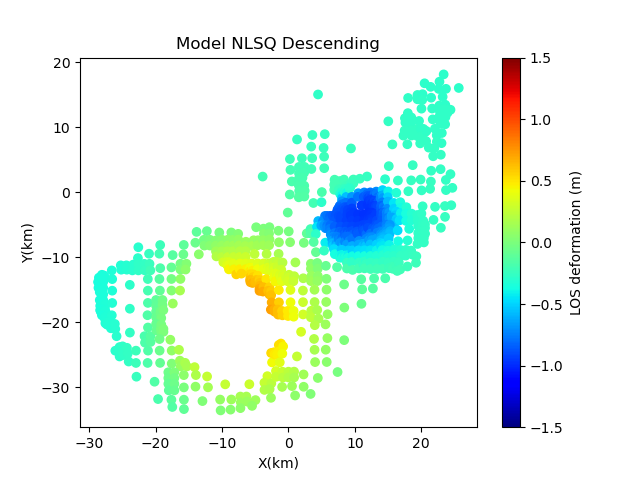

In [20]:
plt.figure()
plt.title('Model NLSQ Descending')
plt.scatter(obs_des.xs/1e3,obs_des.ys/1e3,c=los_des*1e2,cmap='jet',vmin=-1.5,vmax=1.5)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (cm)')

## Run Bayesian inversion

Here the Bayesian inversion is run. The user can interrupt the inversion at any moment and the results will be saved in a pkl file

In [ ]:
trace=inv_des.mcmc_em('unimak_insar_okmc')

  0%|          | 0/235714 [00:00<?, ?it/s]/home/jovyan/.local/envs/vmod-test/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  6%|▌         | 13515/235714 [38:56<10:04:52,  6.12it/s]

In [22]:
import pickle
with open('unimak_insar_okmc.pkl','rb') as handle:
    dic=pickle.load(handle)

trace=[dic[key] for key in dic.keys()]

## Plot posterior distributions for the parameters

Here we used the corner library to plot the posterior distributions for the parameters.

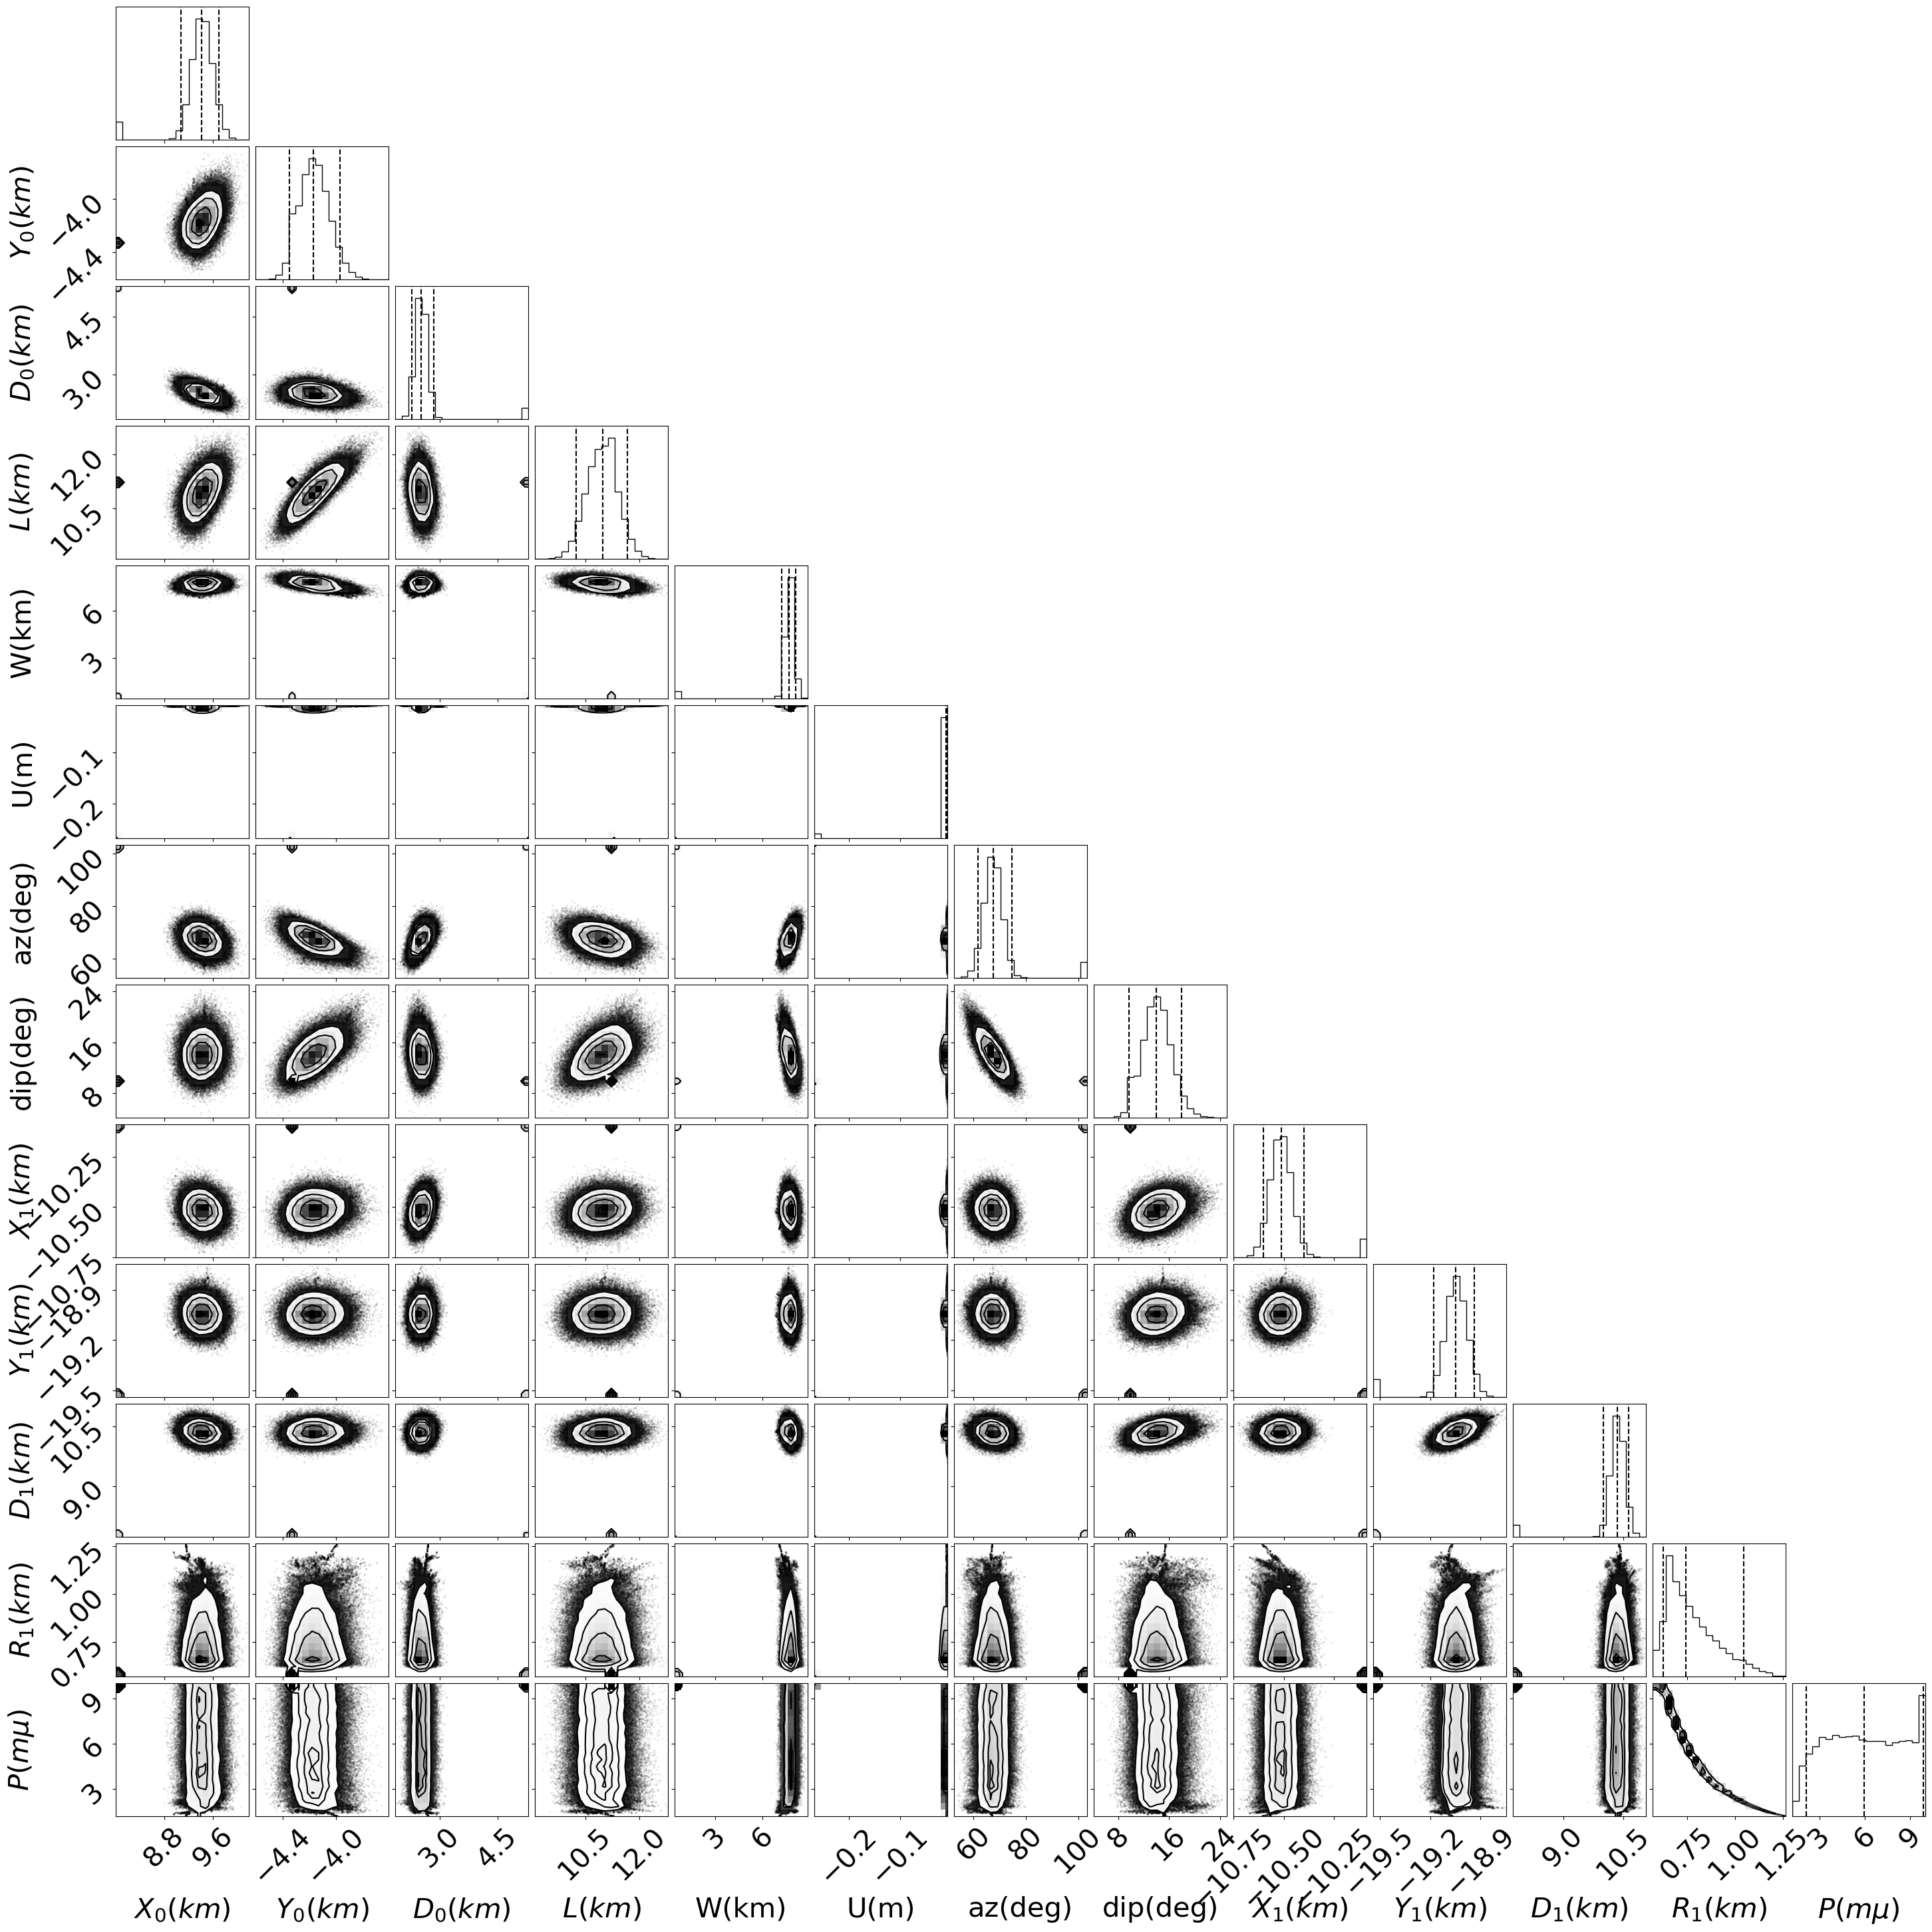

In [25]:
%matplotlib inline
data=[]
labels=[]
parnames,orders=inv_des.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)

newdata=np.copy(data)
newdata[0:5,:]=newdata[0:5,:]/1e3
newdata[8:12,:]=newdata[8:12,:]/1e3
newdata[12,:]=newdata[12,:]*1e3

labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$',r'$D_{0}(km)$','$L(km)$','W(km)','U(m)','az(deg)','dip(deg)',r'$X_{1} (km)$',r'$Y_{1} (km)$',r'$D_{1}(km)$',r'$R_{1}(km)$',r'$P(m\mu)$']

plt.rcParams.update({'font.size': 30})

figure = corner.corner(newdata.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],max_n_ticks=3,labelpad=0.3,
                       show_titles=False, title_kwargs={"fontsize": 30})

plt.savefig('histograms')

## Find the MAP solution from the Bayesian inversion

These cells show how to find the MAP solution from the posterior distributions

In [28]:
bl=np.array([np.percentile(data[i,:],5) for i in range(data.shape[0])])
bh=np.array([np.percentile(data[i,:],95) for i in range(data.shape[0])])

import copy

obs_desn=copy.deepcopy(obs_des)
obs_desn.add_err(obs_desn.err*0+1)

okn = Okada(obs_desn)
okn.set_type('open')
#Bounds for parameters
okn.set_bounds(low_bounds = bl[0:8], high_bounds = bh[0:8])

mctn = Mctigue(obs_desn)
#Bounds for parameters
mctn.set_bounds(low_bounds = bl[8::], high_bounds = bh[8::])

invb=Inverse(obs_desn)
invb.register_source(okn)
invb.register_source(mctn)

In [29]:
paramsn=invb.nlsq()

100%|██████████| 64/64 [08:33<00:00,  8.03s/it]


## Plot MAP solution

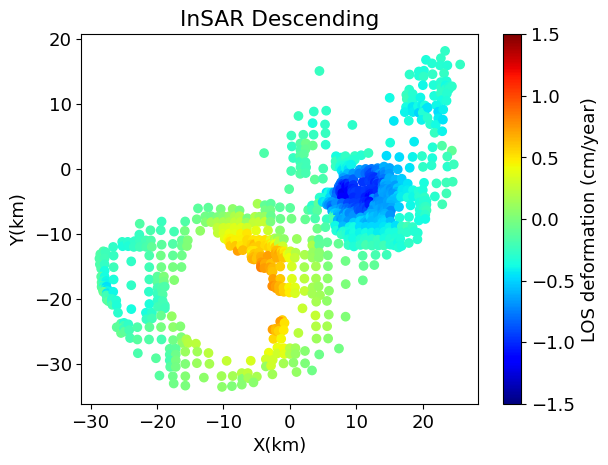

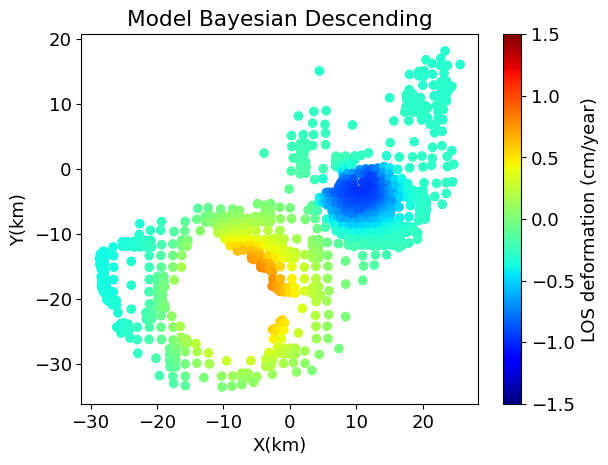

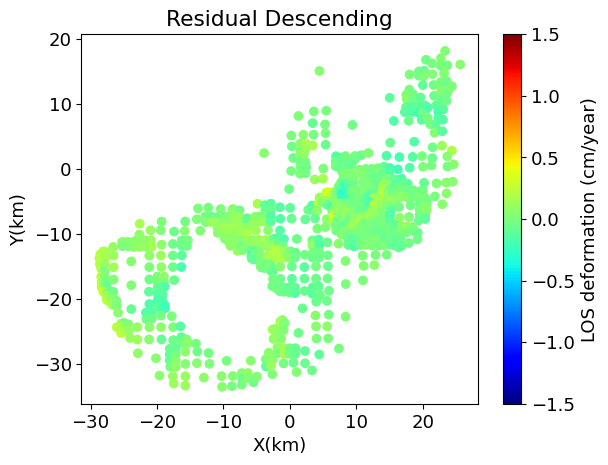

In [30]:
plt.rcParams.update({'font.size': 13})

los_des=invb.forward(paramsn)

plt.figure()
plt.title('InSAR Descending')
plt.scatter(obs_des.xs/1e3,obs_des.ys/1e3,c=obs_des.get_data()*1e2,cmap='jet',vmin=-1.5,vmax=1.5)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (cm/year)')

plt.figure()
plt.title('Model Bayesian Descending')
plt.scatter(obs_des.xs/1e3,obs_des.ys/1e3,c=los_des*1e2,cmap='jet',vmin=-1.5,vmax=1.5)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (cm/year)')

plt.figure()
plt.title('Residual Descending')
plt.scatter(obs_des.xs/1e3,obs_des.ys/1e3,c=(obs_des.get_data()-los_des)*1e2,cmap='jet',vmin=-1.5,vmax=1.5)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (cm/year)')